In [1]:
# Import Libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import pingouin as pg
import seaborn as sns
import numpy as np
import statsmodels.api as sm # biblioteca de modelagem estatística
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import pearsonr # correlações de Pearson

In [2]:
# Create a Spark Session
spark = SparkSession.builder.appName("PCA").getOrCreate()

In [3]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('weather_august.csv')
# Create a Pandas Dataframe
aug_df = spark.createDataFrame(df)
# Convert the PySpark DataFrame to a Pandas DataFrame
aug_df_pd = aug_df.toPandas()
# Show the Dataframe
aug_df_pd

,Precipitation,Global_Radiation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed
0,0.0,0.1,929.30,12.15,12.10,100.0,2.70
1,0.0,5.0,929.75,12.35,12.35,100.0,2.45
2,0.0,135.8,930.20,12.55,12.55,100.0,2.50
3,0.0,488.0,930.40,13.35,13.35,100.0,2.90
4,0.0,1631.1,930.60,15.50,13.65,89.5,3.05
...,...,...,...,...,...,...,...
370,0.0,2859.9,933.70,17.75,9.65,59.5,4.85
371,0.0,2399.6,932.75,17.60,10.10,62.0,5.60
372,0.0,1711.2,932.35,16.30,11.00,71.0,6.20
373,0.0,896.8,932.15,14.80,11.25,79.5,6.10


In [4]:
# Performing PCA 

# Matrix of correlations between variables
matriz_corr = pg.rcorr(aug_df_pd, method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
matriz_corr

,Precipitation,Global_Radiation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed
Precipitation,-,*,,**,,**,
Global_Radiation,-0.0995,-,*,***,***,***,
Avarage_Atmospheric_Pressure,-0.0124,0.0867,-,***,,***,
Avarage_Temperature,-0.1032,0.4812,-0.6258,-,***,***,***
Avarage_Dew_Temperature,0.0642,-0.3487,-0.0152,-0.1944,-,***,***
Avarage_Relative_Humidity,0.129,-0.6099,0.4303,-0.8452,0.6541,-,
Avarage_Wind_Speed,0.0672,0.0526,0.0729,-0.1992,-0.421,-0.0716,-


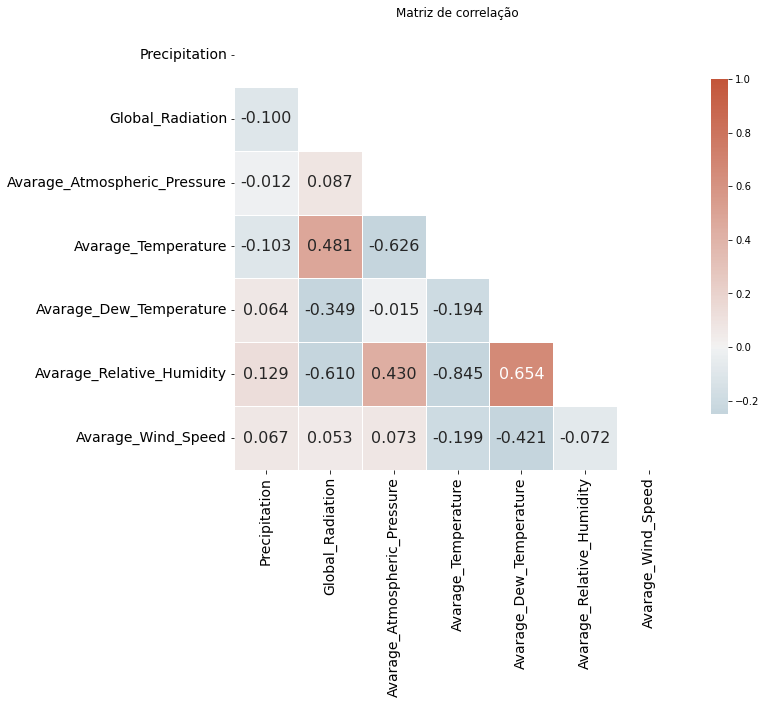

In [5]:
# Another way to plot the same information

corr = aug_df_pd.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

sns.heatmap(aug_df_pd.corr(), 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -.25,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.3f', 
            annot_kws={'size': 16},
            cbar_kws={"shrink": .75})

plt.title('Matriz de correlação')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_ylim(len(corr))

plt.show()

In [6]:
# Bartlett test
bartlett, p_value = calculate_bartlett_sphericity(aug_df_pd)
print(f'Bartlett statistic: {bartlett}')
print(f'p-value : {p_value}')

# KMO Statisticskmo_all
kmo_model = calculate_kmo(aug_df_pd)
print(f'kmo_model : {kmo_model}')

Bartlett statistic: 1940.3054088601662
p-value : 0.0
kmo_model : (array([0.61758167, 0.54295877, 0.57536805, 0.47460896, 0.31684385,
       0.48010667, 0.63730186]), 0.4665623403168582)


In [7]:
# Defining the PCA (preliminary procedure)
fa = FactorAnalyzer()
fa.fit(aug_df_pd)

# Getting the Eigenvalues ​​(eigenvalues)
ev, v = fa.get_eigenvalues()
print(ev)

[2.80822599 1.55657761 1.07973316 0.88884305 0.49062906 0.15974613
 0.01624501]


In [8]:
# Kaiser Criterion

# Check eigenvalues ​​with values ​​greater than 1
# There are three components above 1

# Parameterizing the PCA for two factors (eigenvalues ​​> 1)
fa.set_params(n_factors = 3, method = 'principal', rotation = None)
fa.fit(aug_df_pd)

# Eigenvalues, variances and accumulated variances
eigen_fatores = fa.get_factor_variance()
eigen_fatores

eigen_table = pd.DataFrame(eigen_fatores)
eigen_table.columns = [f"Fator {i+1}" for i, v in enumerate(eigen_table.columns)]
eigen_table.index = ['Eigenvalue','Variance', 'Accumulated Variance']
eigen_table = eigen_table.T

eigen_table

,Eigenvalue,Variance,Accumulated Variance
Fator 1,2.808226,0.401175,0.401175
Fator 2,1.556578,0.222368,0.623543
Fator 3,1.079733,0.154248,0.777791


In [9]:
# Determining factor loadings
factor_loads = fa.loadings_

load_table = pd.DataFrame(factor_loads)
load_table.columns = [f"Fator {i+1}" for i, v in enumerate(load_table.columns)]
load_table.index = aug_df_pd.columns
load_table

,Fator 1,Fator 2,Fator 3
Precipitation,0.171671,0.023464,0.729986
Global_Radiation,-0.666681,0.254033,-0.374332
Avarage_Atmospheric_Pressure,0.494829,0.585321,-0.478705
Avarage_Temperature,-0.873458,-0.414721,0.028363
Avarage_Dew_Temperature,0.597031,-0.646113,-0.099719
Avarage_Relative_Humidity,0.982080,-0.045851,-0.023657
Avarage_Wind_Speed,-0.074698,0.746549,0.407754


In [10]:
# Determining commonalities
commonalities = fa.get_communalities()

commonalities_table = pd.DataFrame(commonalities)
commonalities_table.columns = ['Commonalities']
commonalities_table.index = aug_df_pd.columns
commonalities_table

,Commonalities
Precipitation,0.562901
Global_Radiation,0.649120
Avarage_Atmospheric_Pressure,0.816614
Avarage_Temperature,0.935727
Avarage_Dew_Temperature,0.783852
Avarage_Relative_Humidity,0.967144
Avarage_Wind_Speed,0.729179


In [11]:
# Factor results for the dataset observations (predict)
predict_fatores= pd.DataFrame(fa.transform(aug_df_pd))
predict_fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(predict_fatores.columns)]

predict_fatores

,Fator 1,Fator 2,Fator 3
0,0.996831,-0.644043,0.064496
1,1.021094,-0.706631,-0.038953
2,1.003864,-0.666082,-0.133196
3,0.911611,-0.630033,-0.235168
4,0.332838,-0.505379,-0.667677
...,...,...,...
370,-0.744807,0.860953,-0.982714
371,-0.593853,0.821514,-0.571527
372,-0.156231,0.750288,-0.181711
373,0.296769,0.596293,0.119979


In [12]:
# Adding to dataset
aug_df_pd_pf = pd.concat([aug_df_pd.reset_index(drop=True), predict_fatores], axis=1)

In [13]:
# Identifying factor scores
scores = fa.weights_

table_scores = pd.DataFrame(scores)
table_scores.columns = [f"Fator {i+1}" for i, v in enumerate(table_scores.columns)]
table_scores.index = aug_df_pd.columns
table_scores

,Fator 1,Fator 2,Fator 3
Precipitation,0.061132,0.015074,0.676080
Global_Radiation,-0.237403,0.163200,-0.346689
Avarage_Atmospheric_Pressure,0.176207,0.376031,-0.443355
Avarage_Temperature,-0.311035,-0.266432,0.026268
Avarage_Dew_Temperature,0.212601,-0.415085,-0.092356
Avarage_Relative_Humidity,0.349716,-0.029456,-0.021910
Avarage_Wind_Speed,-0.026600,0.479609,0.377643


In [14]:
# Correlation between factors

# Next, it appears that the correlation between the factors is zero (orthogonal)
corr_fator = pg.rcorr(aug_df_pd_pf[['Fator 1','Fator 2', 'Fator 3']], method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
corr_fator

,Fator 1,Fator 2,Fator 3
Fator 1,-,,
Fator 2,-0.0,-,
Fator 3,-0.0,0.0,-


In [15]:
# Creating a ranking
aug_df_pd_pf['Ranking'] = 0

for index, item in enumerate(list(eigen_table.index)):
    variancia = eigen_table.loc[item]['Variance']

    aug_df_pd_pf['Ranking'] = aug_df_pd_pf['Ranking'] + aug_df_pd_pf[eigen_table.index[index]]*variancia
    
aug_df_pd_pf.head()

,Precipitation,Global_Radiation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed,Fator 1,Fator 2,Fator 3,Ranking
0,0.0,0.1,929.30,12.15,12.10,100.0,2.70,0.996831,-0.644043,0.064496,0.266638
1,0.0,5.0,929.75,12.35,12.35,100.0,2.45,1.021094,-0.706631,-0.038953,0.246497
2,0.0,135.8,930.20,12.55,12.55,100.0,2.50,1.003864,-0.666082,-0.133196,0.234064
3,0.0,488.0,930.40,13.35,13.35,100.0,2.90,0.911611,-0.630033,-0.235168,0.189342
4,0.0,1631.1,930.60,15.50,13.65,89.5,3.05,0.332838,-0.505379,-0.667677,-0.081842


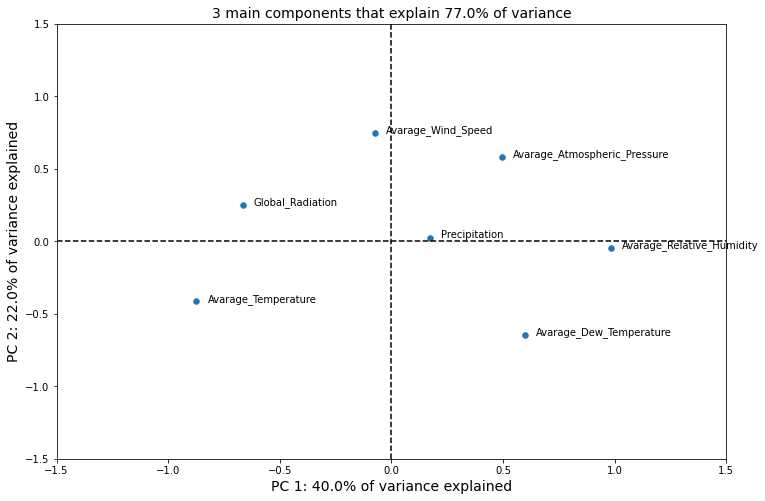

In [16]:
# Chart of factor loadings and their variances in the main components
plt.figure(figsize=(12,8))

table_loads_chart = load_table.reset_index()

plt.scatter(table_loads_chart['Fator 1'], table_loads_chart['Fator 2'], s=30)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = table_loads_chart['Fator 1'],
            y = table_loads_chart['Fator 2'],
            val = table_loads_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='black', ls='--')
plt.axvline(x=0, color='black', ls='--')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.title(f"{eigen_table.shape[0]} main components that explain {(eigen_table['Variance'].round(2).sum())*100}% of variance", fontsize=14)
plt.xlabel(f"PC 1: {(eigen_table.iloc[0]['Variance'].round(2))*100}% of variance explained", fontsize=14)
plt.ylabel(f"PC 2: {(eigen_table.iloc[1]['Variance'].round(2))*100}% of variance explained", fontsize=14)
plt.show()

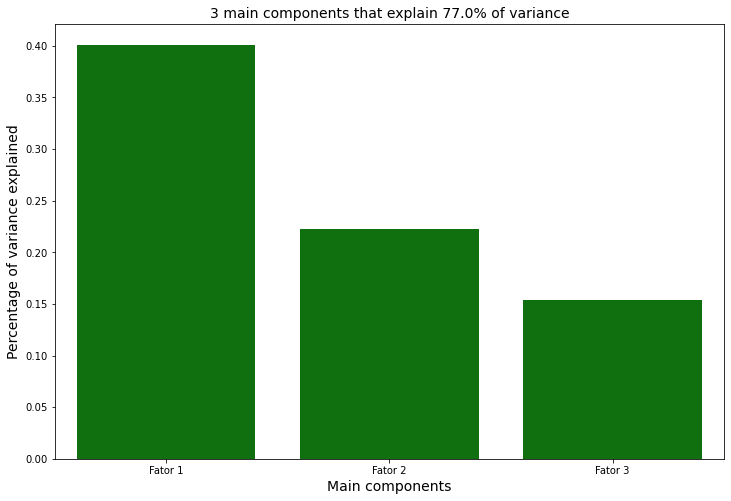

In [17]:
# Plot of the accumulated variance of the principal components
plt.figure(figsize=(12,8))

plt.title(f"{eigen_table.shape[0]} main components that explain {(eigen_table['Variance'].round(2).sum())*100}% of variance", fontsize=14)
sns.barplot(x=eigen_table.index, y=eigen_table['Variance'], data=eigen_table, color='green')
plt.xlabel("Main components", fontsize=14)
plt.ylabel("Percentage of variance explained", fontsize=14)
plt.show()